<a href="https://colab.research.google.com/github/cannonbunny/stock-sentiment-analysis/blob/master/BoW_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import requirements

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from tensorflow import keras
from string import punctuation

from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sentiment = pd.read_csv('/content/drive/My Drive/all-data.csv', encoding='latin-1', names=['score', 'text'])
sentiment['score'] = sentiment['score'].astype(int)

Mounted at /content/drive


# Text cleaning and tokenizing

In [ ]:
lemma = WordNetLemmatizer()
stop = set(stopwords.words('english'))
stop.update(punctuation)

def token_text(t):
    new_text = []
    for w in word_tokenize(t):
        if w.lower() not in stop:
            pos = pos_tag([w])
            pos_test = ''
            if pos[0][1].startswith('V'):
              pos_test = wordnet.VERB
            elif pos[0][1].startswith('J'):
                pos_test = wordnet.ADJ
            elif pos[0][1].startswith('R'):
                pos_test = wordnet.ADV
            else:
                pos_test = wordnet.NOUN
            new_w = lemma.lemmatize(w, pos=pos_test)
            new_text.append(new_w)
    return ' '.join(new_text)

In [ ]:
sentiment['text'] = sentiment['text'].apply(token_text)
x_train,x_test,y_train,y_test = train_test_split(sentiment['text'],sentiment['score'],test_size = 0.2)
count_vec = CountVectorizer(max_features=3200, ngram_range=(1,2))
x_train_features = count_vec.fit_transform(x_train).todense()
x_test_features = count_vec.transform(x_test).todense()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Training, testing and plotting

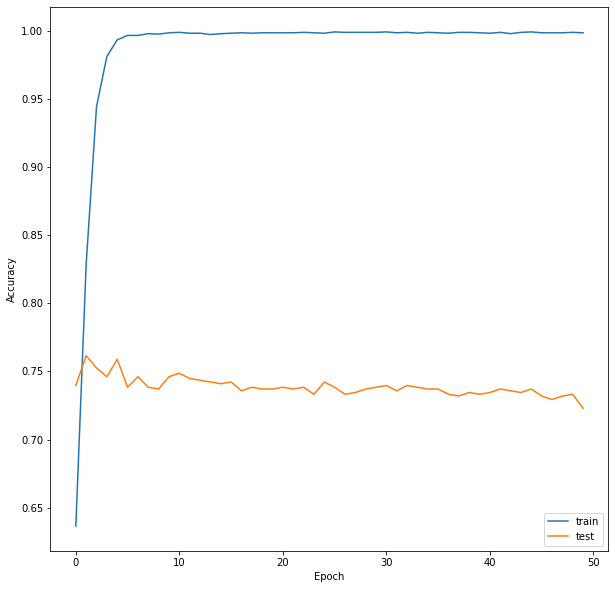

In [ ]:
def get_bow_model(input_shape):
  model = Sequential()
  model.add(Dense(units=128, activation='relu', input_dim=input_shape))
  model.add(Dropout(0.1))
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=3, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

model = get_bow_model(x_train_features.shape[1])
history = model.fit(x_train_features, y_train, validation_split=0.2, epochs=50, verbose=0)

plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()